<a href="https://colab.research.google.com/github/e-abtahi/Machine_Learning_Portfolio/blob/main/Application_Case_Engineering_College/EngineeringCollege.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://images.pexels.com/photos/1454360/pexels-photo-1454360.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2" width="800" height="500"></center>

<b><h2><center>Engineering Colleges Case Study</center></h2></b>

## Problem Statement

### Context

Education is fast becoming a very competitive sector with hundreds of institutions to choose from. It is a life-transforming experience for any student and it has to be a thoughtful decision. There are ranking agencies that do a survey of all the colleges to provide more insights to students. Agency RankForYou wants to leverage this year's survey to roll out an editorial article in leading newspapers, on the state of engineering education in the country. Head of PR (Public Relations) comes to you, the data scientist working at RankForYou, and asks you to come up with evidence-based insights for that article.

### Objective

As a data scientist working at RankForYou, you have been asked to identify the different types of engineering colleges in the country to better understand the state of affairs. The key questions that need to be answered are:
- How many different types (clusters/segments) of colleges can be found from the data?
- How do these different groups of colleges differ from each other?
- Do you get slightly different solutions from two different techniques? How would you explain the difference?


### Data Description

The data contains survey results for 26 engineering colleges. The initial survey data has been summarized into a rating scale of 1-5 for different factors.

**Factor rating index**
 - 1 - Very low
 - 2 - Low
 - 3 - Medium
 - 4 - High
 - 5 - Very high

**Data Dictionary**
 - SR_NO: Serial Number
 - Engg_College: 26 Engineering colleges with pseudonyms A to Z
 - Teaching: Quality of teaching at the engineering college
 - Fees: Fees at the engineering college
 - Placements: Job placements after a student graduates from the engineering college
 - Internship: Student Internships at the engineering college
 - Infrastructure: Infrastructure of the engineering college

## Importing necessary libraries

In [8]:
# this will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Reading the Dataset

In [9]:
from google.colab import drive
drive.mount('/content/drive')

# loading the dataset
data = pd.read_csv("/content/drive/MyDrive/Engineering_Colleges_Case_Study.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Overview of the Dataset

The initial steps to get an overview of any dataset is to:
- observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- get information about the number of rows and columns in the dataset
- find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.
- check the statistical summary of the dataset to get an overview of the numerical columns of the data

### Checking the shape of the dataset

In [10]:
data.shape

(26, 6)

* The dataset has 26 rows and 7 columns

### Displaying few rows of the dataset

In [11]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,SR_NO,Engg_College,Teaching,Fees,Placements,Infrastructure
18,19,S,3,5,4,3
13,14,N,3,5,3,4
17,18,R,3,4,4,3
3,4,D,5,4,5,4
22,23,W,2,5,1,1
10,11,K,3,4,3,5
19,20,T,3,5,3,3
20,21,U,2,2,2,1
4,5,E,2,5,2,5
2,3,C,4,5,5,5


### Creating a copy of original data

In [12]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

In [13]:
# dropping the serial no. column as it does not provide any information
df.drop("SR_NO", axis=1, inplace=True)

### Checking the data types of the columns for the dataset

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Engg_College    26 non-null     object
 1   Teaching        26 non-null     int64 
 2   Fees            26 non-null     int64 
 3   Placements      26 non-null     int64 
 4   Infrastructure  26 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 1.1+ KB


**Observations**

- *Engg_College* is a categorical variable with 26 levels that indicate each college's name.
- The 5 rating variables are of type *int* (integer).

### Statistical summary of the dataset

In [15]:
df.describe()

,Teaching,Fees,Placements,Infrastructure
count,26.000000,26.000000,26.000000,26.000000
mean,2.807692,3.576923,2.884615,3.384615
std,1.132051,1.331858,1.531716,1.298520
min,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.250000,1.250000,3.000000
50%,3.000000,4.000000,3.000000,3.000000
75%,3.000000,5.000000,4.000000,4.750000
max,5.000000,5.000000,5.000000,5.000000


**Observations**

- The median value of fees is 4, indicating that most of the engineering colleges have high fees.
- The mean and median of other ratings lie between 2 and 3, except the mean infrastructure rating.

### Checking for missing values

In [16]:
# checking for missing values
df.isna().sum()

Engg_College      0
Teaching          0
Fees              0
Placements        0
Infrastructure    0
dtype: int64

- There are no missing values in our data

## Exploratory Data Analysis

### Univariate Analysis

In [17]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

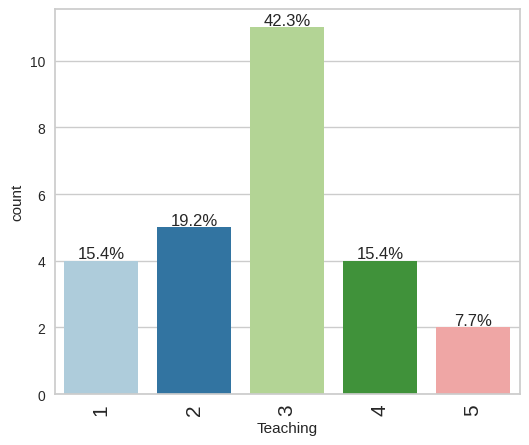

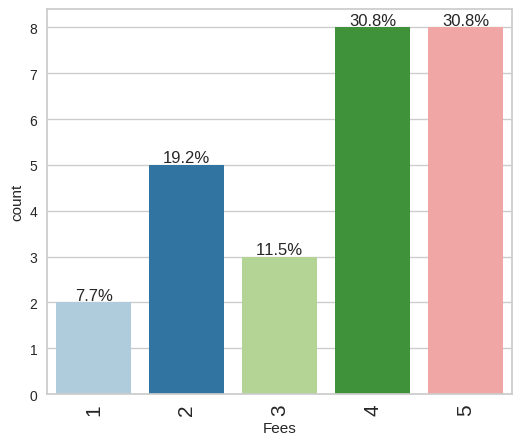

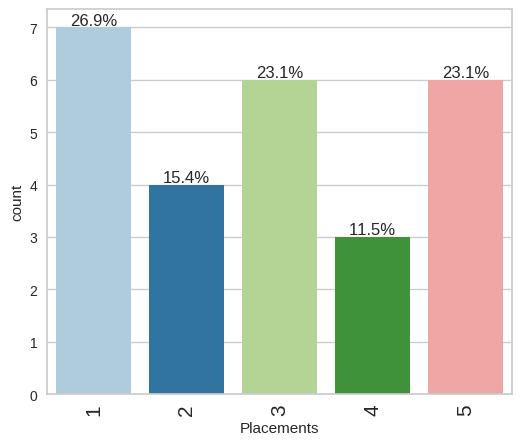

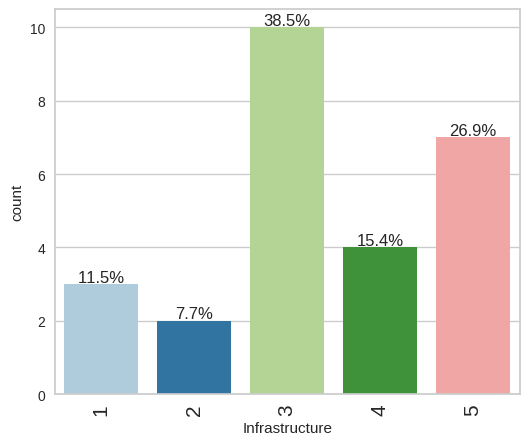

In [18]:
num_col = df.select_dtypes(include=np.number).columns.tolist()
for item in num_col:
    labeled_barplot(df, item, perc=True)

**Observations**

- More than 70% of the colleges have a rating of 3 or more for placements.
- More than 80% of the colleges have a rating of 3 or more for infrastructure.
- More than 60% of the colleges have a rating of 3 or more for teaching.

### Bivariate Analsysis

**Let's check for correlations.**

<ipython-input-19-d207b7d46160>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")


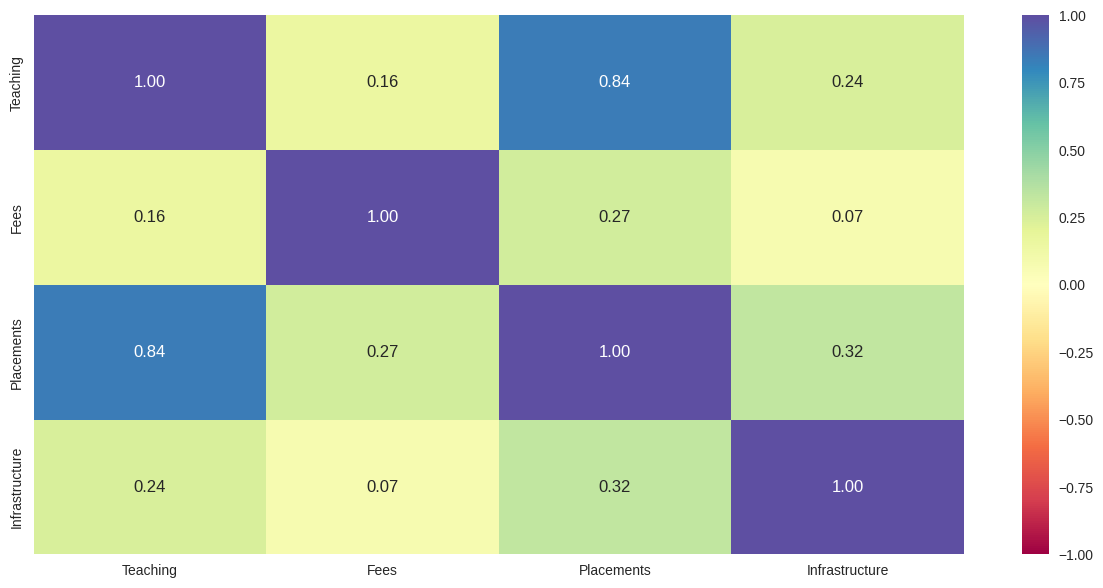

In [19]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observation**

- Rating for teaching is strongly positively correlated with the rating for placements.
- This is obvious because if teaching quality is high, students are more likely to get placements.

### **What is feature scaling?**

Feature scaling is a class of statistical techniques that, as the name implies, scales the features of our data so that they all have a similar range. You'll understand better if we look at an example:

If you have multiple independent variables like age, salary, and height, With their range as (18–100 Years), (25,000–75,000 Euros), and (1–2 Meters) respectively, feature scaling would help them all to be in the same range.

### **Why feature scaling is improtant in Unsupervised Learning?**

Feature scaling is specially relevant in machine learning models that compute some sort of distance metric, like most clustering methods like K-Means.

So, scaling should be done to avoid the problem of one feature dominating over others because the unsupervised learning algorithm uses distance to find the similarity between data points.

### For this case study, we will not scale the features because all of the variables in the data have the same units, which range from 1 to 5.

## K-Means Clustering

In [20]:
# Subseting the data
subset_df = df.drop("Engg_College", axis=1)

In [21]:
subset_df.columns

Index(['Teaching', 'Fees', 'Placements', 'Infrastructure'], dtype='object')

In [22]:
num_col = ["Teaching", "Fees", "Placements", "Infrastructure"]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Number of Clusters: 1 	Average Distortion: 2.445161236901436
Number of Clusters: 2 	Average Distortion: 1.8386954425352884
Number of Clusters: 3 	Average Distortion: 1.5663251587239047
Number of Clusters: 4 	Average Distortion: 1.319866756300917
Number of Clusters: 5 	Average Distortion: 1.1702052828266019
Number of Clusters: 6 	Average Distortion: 1.0528194717572086
Number of Clusters: 7 	Average Distortion: 0.8865332197832502
Number of Clusters: 8 	Average Distortion: 0.7536430520826071


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

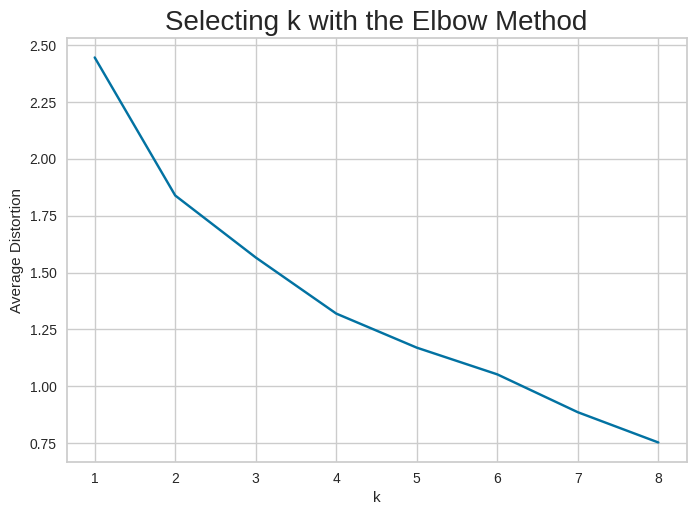

In [23]:
clusters = range(1, 9)
meanDistortions = []  # Create a empty list

for k in clusters:
    model = KMeans(n_clusters=k)  # Initialize KMeans
    model.fit(subset_df)  # Fit kMeans on the data
    prediction = model.predict(subset_df)  # Predict the model on the data
    distortion = (
        sum(np.min(cdist(subset_df, model.cluster_centers_, "euclidean"), axis=1))
        / subset_df.shape[0]  # Find distortion
    )

    meanDistortions.append(
        distortion
    )  # Append distortion values to the empty list created above

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")  # Title of X-axis
plt.ylabel("Average Distortion")  # Title of y-axis
plt.title("Selecting k with the Elbow Method", fontsize=20)  # Title of the plot

**In the above plot, the elbow is seen for K=2 and 4 but if you observe the Average distortion results, there is some drop in distortion at K= 5**

**Q) How do we determine the optimal K value when the elbows are observed at 3 or more K values from the elbow curve?**

**To make a better decision about the number of clusters, we can look at the silhouette score for different K values.**

### What is silhouette score?

Silhouette score is one of the methods for evaluating the quality of clusters created using clustering algorithms such as K-Means. The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Silhouette score has a range of [-1, 1].

* Silhouette coefficients near +1 indicate that the sample is far away from the neighboring clusters.
* Silhouette score near -1 indicate that those samples might have been assigned to the wrong cluster.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

For n_clusters = 2, silhouette score is 0.38121701144257797
For n_clusters = 3, silhouette score is 0.4288415910208104
For n_clusters = 4, silhouette score is 0.36154656907517135
For n_clusters = 5, silhouette score is 0.3768337560059902
For n_clusters = 6, silhouette score is 0.3993270251334635
For n_clusters = 7, silhouette score is 0.4075043503151385
For n_clusters = 8, silhouette score is 0.45545926155854705
For n_clusters = 9, silhouette score is 0.42510835718983014


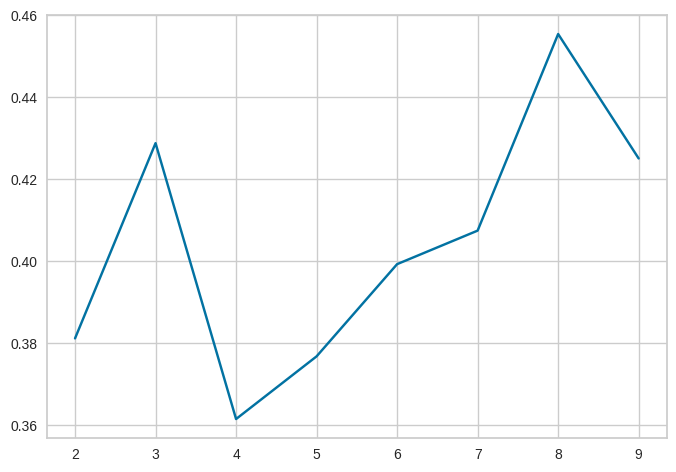

In [24]:
sil_score = []  # Create empty list
cluster_list = list(range(2, 10))  # Creating a list of range from 2 to 10
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)  # Initializing KMeans algorithm
    preds = clusterer.fit_predict((subset_df))  # Predicting on the data
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_df, preds)  # Cacalculating silhouette score
    sil_score.append(score)  # Appending silhouette score to empty list created above
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**From the silhouette scores, it seems that 7 is a good value of k.Let's do deeper investigation for different K values using  SilhouetteVisualizer**

### How to interpret the results of SilhouetteVisualizer?

Below are the points that every cluster needs to satisfy for selecting the optimal K-value.
  - There should be no negative silhouette coefficent value
  - All the clusters should cross the avg silhouette score
  - All the clusters should have the different variations (width)
  - All the clusters should have different silhouette score
  
**Note**
1. Width of each cluster refers to the size of each cluster. (Number of data points present in each cluster)
2. Horizontal line refers to the Silhouette score of each cluster.
3. Dotted red line is an Average Silhouette score.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


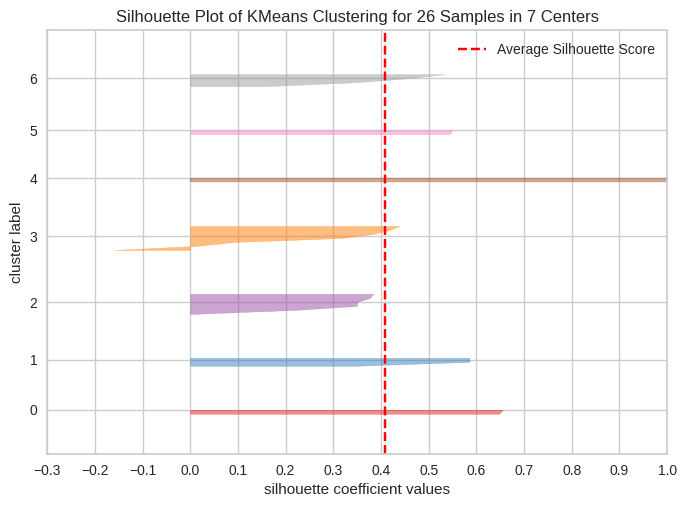

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 26 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [25]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(7, random_state=1))
visualizer.fit(subset_df)
visualizer.show()

* **From the above plot, we can see that cluster with label 0 silhoutte score is not more than Average silhouette score , so k=7 will not be an appropriate value. Let's visualize for k=6**.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


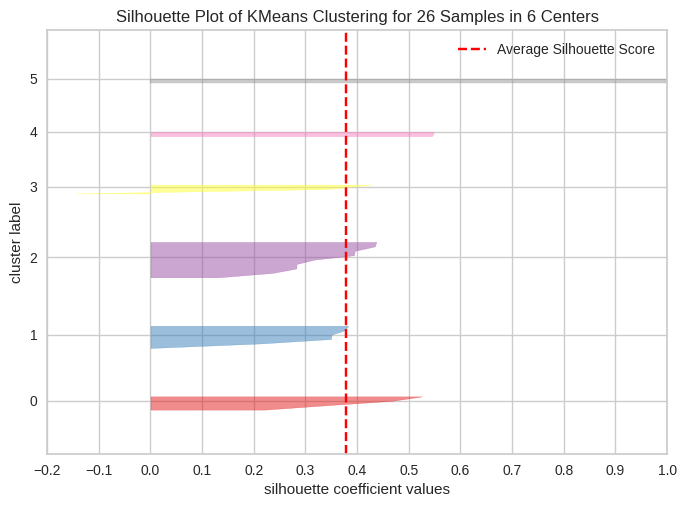

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 26 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [26]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))
visualizer.fit(subset_df)
visualizer.show()

* **From the above plot, we can observe that cluster with label 2,4 and 5 has almost same number of observations (Width), so k=6 will not be an appropriate value. Let's visualize for k=5**.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


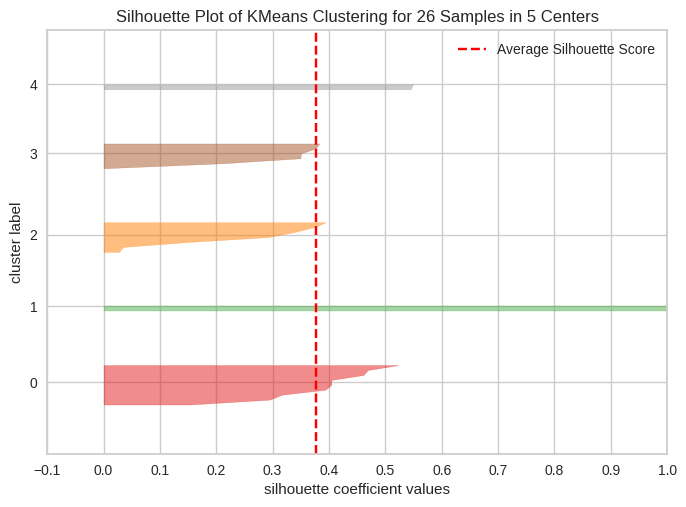

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 26 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [27]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_df)
visualizer.show()

* **From the above plot, we can see that cluster with label 0 and 1 are having same width and silhoutte score,so k=5 will not be an appropriate value Let's visualize for k=4.**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


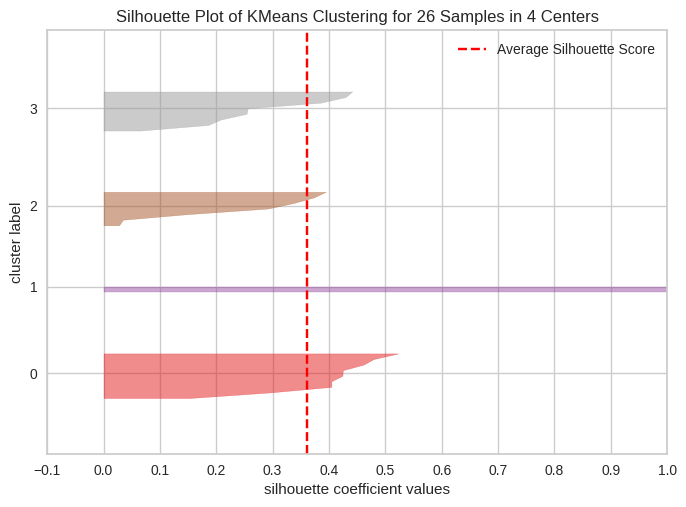

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 26 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [28]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_df)
visualizer.show()

* **From the above plot, we can see that all the all the clusters have crossed Avg silhoutte score, all the clusters have different silhoutte score and have different width size, but the silhoutte score is very less. Let's visualize K=3**.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


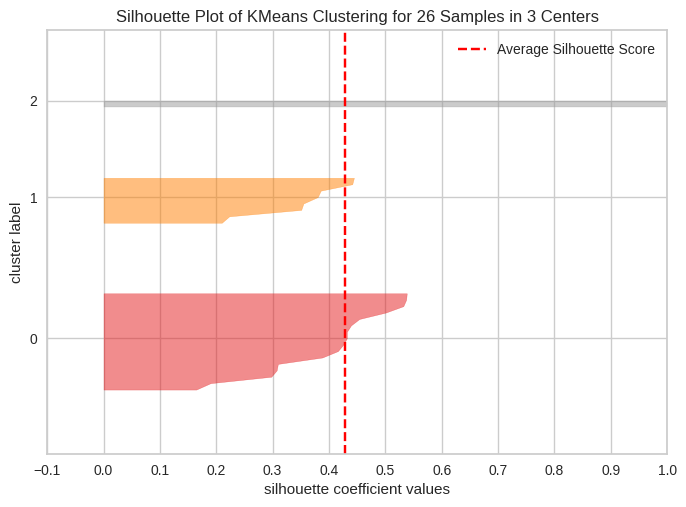

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 26 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [29]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_df)
visualizer.show()

* **From the above plot, we can see that all the clusters have crossed Avg silhouette score, all the clusters have different silhouette scores and have different width sizes, but there is no elbow at K=3, so k=3 will not be an appropriate value. Let's visualize K=2 and decide.**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


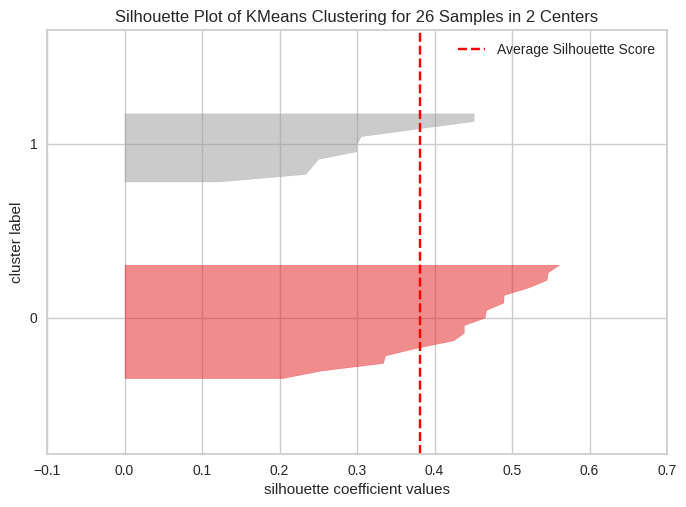

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 26 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [30]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(subset_df)
visualizer.show()

* **We can see from the plot above that all the clusters meet the requirements. So, let's take 2 as the appropriate no. of clusters(K) as the silhouette score is high enough for all the 2-clusters(above average silhouette score), and there is a knick at 2 in the elbow curve.**

### Applying KMeans clustering for k=2

In [31]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(subset_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=0)

In [32]:
# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = kmeans.labels_

### Cluster Profiling

In [33]:
cluster_profile = df.groupby("K_means_segments").mean()

<ipython-input-33-695933a42b1b>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_profile = df.groupby("K_means_segments").mean()


In [34]:
cluster_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments")["Fees"].count().values
)

In [35]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Teaching,Fees,Placements,Infrastructure,count_in_each_segment
K_means_segments,,,,,
0,1.900000,2.700000,1.300000,2.600000,10
1,3.375000,4.125000,3.875000,3.875000,16


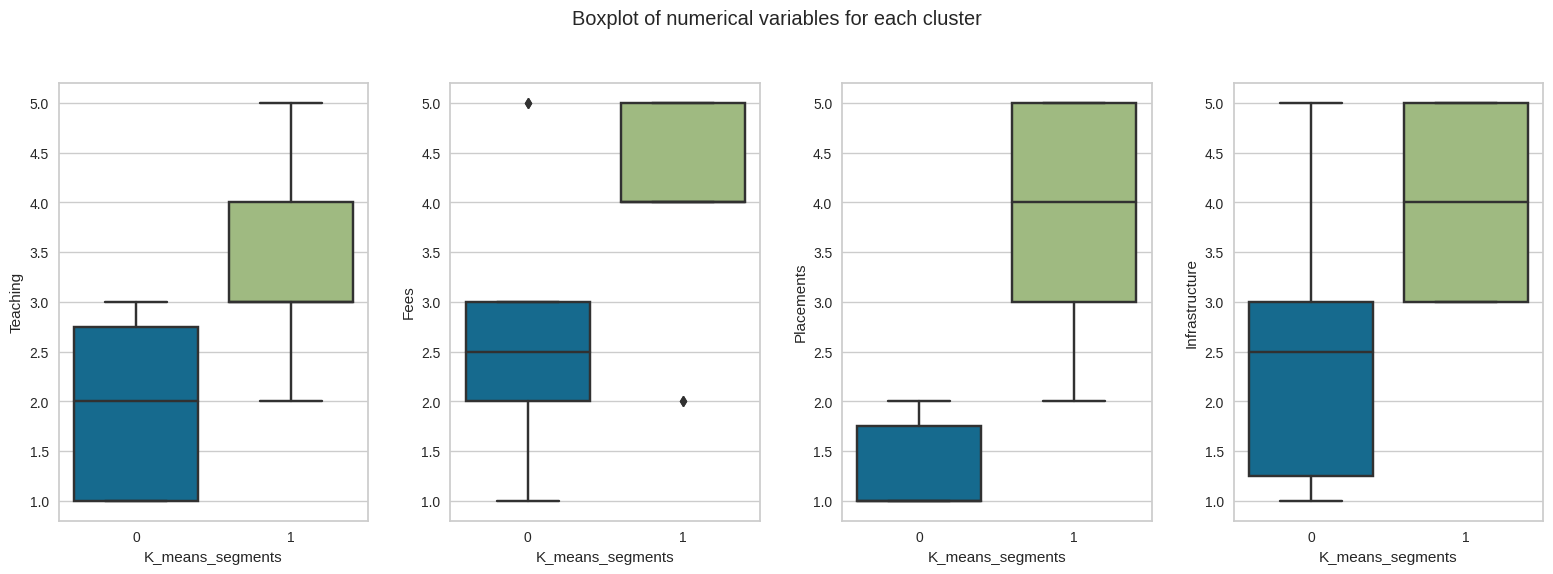

In [36]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(4):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

<ipython-input-37-35f89b1fbcd0>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))


<Axes: xlabel='K_means_segments'>

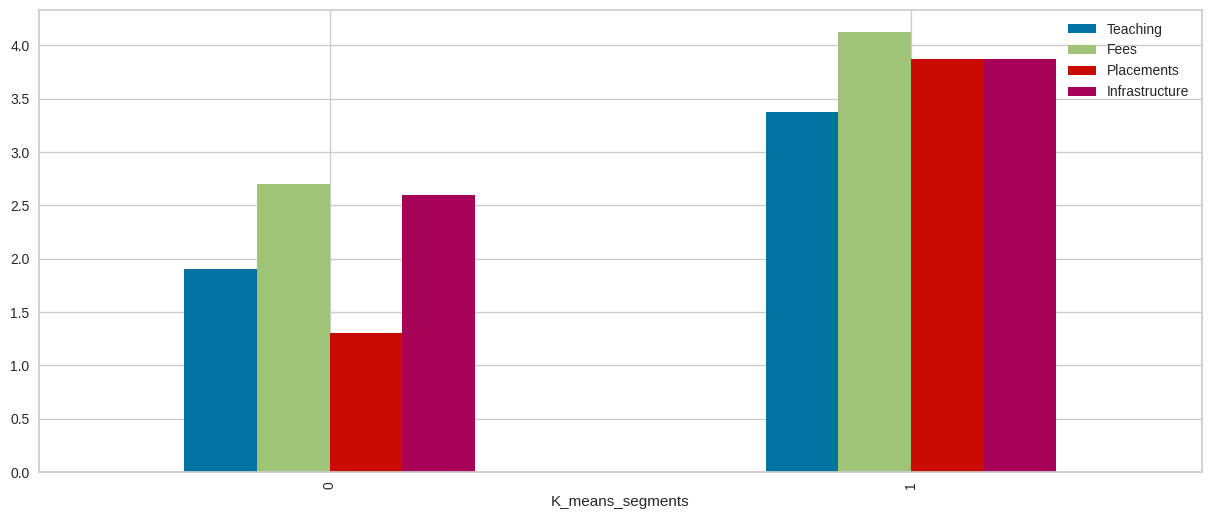

In [37]:
df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

### Insights

- **Cluster 0**:
    - Teaching ratings are low.
    - Fees range from low to moderate for colleges in this cluster.
    - Placement and ratings are very low.
    - Infrastructure ratings are low  to moderate.


- **Cluster 1**:
    - Teaching ratings are moderate to high.
    - Fees ratings for colleges in this cluster are high.
    - Placement ratings are high.
    - Infrastructure ratings are high.

### Business Recommendations

- **Cluster 0**: These are the Tier 2 and 3 colleges which have low fees and very decent infrastructure, but do not offer proper value-for-money in terms of teaching and placements. **This cluster of colleges will need to concentrate more on onboarding better faculty and securing tie-ups with corporates to improve placements opportunities.**


- **Cluster 1**: These are the Tier 1 Colleges and have excellent teaching, infrastructure & placements while maintaining a high fee. **Corporates looking for the best candidates can approach this cluster for placements.**

##### Happy Learning!